# VAE Theory

All theory is from https://arxiv.org/abs/1606.05908.

Notation:
- $X$ is a data point in our dataset
- $z$ is the latent representation of a data point
- $\theta$ is the parameters for our model, which will be a distribution for $P(X|z;\theta)$. Specifically, our model is a mapping from the latent representation to a data point.
- $D$ is our entire dataset, so $X\in D$.
<!-- 
- $f(z;\theta)$ is a map from latent variables z to a point estimate for a data point, X.)
<> - $Q(z|X)$ is a "surrogate" distribution to approximate the probability $P(z|X)$. Assuming we choose that Q(z|X) is normal, then $\mu(X;\phi)$ and $\Sigma(X;\phi)$ are the mean and variance, respectively.
-->


Explanation
- We wish to maximising the probability of our data under our model,
\begin{equation}
P(X) = \int P(X|z; \theta) P(z)dz.
\end{equation}
- When $X$ is continuous, it is common to use a normal distribution for our model:
$$P(X|z; \theta) = N(f(z;\theta), \sigma^2 I).$$
Here, $f(z;\theta)$ is our point estimate for a mapping from the latent representation to the data points, i.e. $f:\mathcal{Z} \times \Theta\rightarrow \mathcal{X}$, where any $z\in \mathcal{Z}$, $\theta \in \Theta$ and $X \in \mathcal{X}$. Also, $\sigma^2$ is a hyperparameter of the model, and is set beforehand.
- We say that the samples of $z$ are from a $N(0, I)$ distribution, so $f(z; \theta)$ is left with the responsiblity of first converting these normal samples into latent variables which are more representative/useful. This uses the fact that any distribution in $d$ dimensions can be generated by taking a set of $d$ variables that are normally distributed and mapping them through a sufficiently complicated function (this is an extension of inverse transform sampling).
- To allow sufficient flexibility, $f(z;\theta)$ is usually a multi-layer neural network. This allows us to learn a map from $z\sim N(0, \sigma^2 I)$ to something which "looks like" a data point, $X$. 
- A naive approach would be to sample $z_1, ..., z_n$ for very large $n$, then approximate our model evidence as $P(X) \approx \frac{1}{n} \sum_{i=1}^n P(X|z_i; \theta)$. From here we could use gradient descent to optimise $f(z; \theta)$ by maximising $P(X)$. The problem is that in higher dimensional space, $n$ might have to be extremely large before we get an accurate estimate. This is because usually, for most $z$, $P(X|z)$ will be nearly zero. The key idea of Variational Autoencoders is to attempt to sample values of $z$ that are likely to have produced $X$, and then compute $P(X)$ just from these...
- The definition of KL-divergence is
\begin{equation}
D_{KL}(P||Q) = \int P(x) \log \left(\frac{P(x)}{Q(x)}\right)dx.
\end{equation}
Equivalently,
\begin{equation}
D_{KL}(P||Q) = \mathbb{E}_{X\sim P} \left[ \log\left(\frac{P(x)}{Q(x)}\right)\right] = \mathbb{E}_{X\sim P} \left[ \log P(x) - \log Q(x) \right].
\end{equation}
- In VAEs, we explained earlier that we want to sample the values of $z$ which are likely to have produced any particular data point, $X$. We use a "surrogate" distribution to approximate $P(z|X)$, $Q(z|X)$. Then, the KL-divergence between our surrogate distribution $Q(z|X)$ and the probability of latent variables in a particular data point, $P(z|X)$ is given by
\begin{equation*}
D_{KL}(Q(z|X) || P(z|X)) = \mathbb{E}_{z\sim Q} \left[ \log Q(z|X) - \log P(z|X) \right].
\end{equation*}
Now we can apply Bayes Rule:
\begin{align}
P(z|X) &= \frac{P(X|z) P(z)}{P(X)} \implies D_{KL}(Q(z|X) || P(z|X))\\ 
&= \mathbb{E}_{z\sim Q} \left[ \log Q(z|X) - \log \left( \frac{P(X|z) P(z)}{P(X)}\right)\right]\\
&= \mathbb{E}_{z\sim Q} \left[ \log \left( \frac{Q(z|X)}{P(z)}\right) - \log P(X|z) \right] + \log P(X)\\
&= D_{KL}(Q(z|X) || P(z)) - \mathbb{E}_{z\sim Q}\left[ \log P(X|z) \right] + \log P(X).\\
\end{align}

\begin{equation*}
\therefore \log P(X) - F_{KL}(Q(z|X) || P(z)) = \mathbb{E}_{z\sim Q}\left[ \log P(X|z)\right] - D_{KL}(Q(z|X) || P(z))
\end{equation*}

We cannot compute $D_{KL}(Q(z|X) || P(z|X))$ without knowing $P(z|X)$, but a property of KL-divergence is that it is non-negative. Therefore, our expression becomes
\begin{equation*}
\log P(X) \geq \mathbb{E}_{z\sim Q}\left[ \log P(X|z)\right] - D_{KL}(Q(z|X) || P(z)).
\end{equation*}
The LHS is called the evidence, hence the RHS is called the "Evidence Lower BOund" (ELBO). We wish to maximies the evidence (as this corresponds to the observed data being likely under our model), so in VAEs we do this by maximising the RHS and treating $D_{KL}(Q(z|X) || P(z|X))$ as an error term.
- Typically, we set our surrogate distribution as $Q(z|X) \sim N(\mu(X; \phi), \Sigma(X; \phi))$. In practice, $\mu(X; \phi)$ and $\Sigma(X;\phi)$ are again obtained using neural networks, and these are maps from a data point $X$ to the estimated mean and variance for the latent variables, respectively. Hence, the parameters $\phi$ are learned from the data. Note that $\Sigma$ is constrained to be a diagonal matrix, as independence between components is necessary for computational tractibility and encourages disentanglement of latent variables.
- In the ELBO, the term $D_{KL}(Q(z|X) || P(z))$ is a KL-divergence between multivariate Gaussian distributions, hence a closed form expression for the KL-divergence is known. In our case, 
\begin{align}
D_{KL}(Q(z|X) || P(z)) &= D_{KL}(N(\mu(X), \Sigma(X)) || N(0, I))\\
&= \frac{1}{2}\left( \text{trace}(\Sigma(X)) + (\mu(X))^T (\mu(X)) - k - \log \text{det}(\Sigma(X))\right)
\end{align}

But, in the ELBO it is more difficult to compute the term $\mathbb{E}_{z \sim Q} \left[ log P(X|z) \right]$. One approach is to estimate this expectation by sampling many $z$, although this will be expensive. Instead, we can apply the idea from stochastic gradient descent and use a single sample of $z$ to approximate this expectation for a single data point, X. Then, our total loss (over the entire dataset $D$) to minimise with stochastic gradient descent is
\begin{equation}
\mathbb{E}_{X\sim D} \left[ \mathbb{E}_{z \sim Q} \left[ \log P(X|z) \right] - D_{KL} (Q(z|X) || P(z)) \right].
\end{equation}
We estimate the gradient of this by averaging the gradient of
\begin{equation}
\log P(X|z) - D_{KL}(Q(z|X) || P(z))
\end{equation}
for an arbitrary number of samples of $z$ and $X$. The result will converge to the overall gradient (for all $X$, $z$).

- But, the issue with the above gradient estimate is that we can't actually backpropogate through $\mathbb{E}_{z\sim Q} \left[ \log P(X|z) \right]$, as the expectation $\mathbb{E}_{z \sim Q} \left[ \cdot \right]$ depends on $\phi$. Specifically, in general $\triangledown_{\phi} \mathbb{E}_{z\sim Q} \left[ \log P(X|z) \right] \neq \mathbb{E}_{z\sim Q} \left[ \triangledown_{\phi} \log P(X|z) \right]$. In integral form,
\begin{align}
\triangledown_{\phi} \mathbb{E}_{z\sim Q} \left[ \log P(X|z) \right] &= \int_z \triangledown_{\phi} ( Q(z|X) \log P(X|z) ) dz\\
&= \int_z \triangledown_{\phi} (Q(z|X)) \log P(X|z)dz + \int_z Q(z|X) \triangledown_{\phi} ( \log P(X|z) ) dz\\
&= \int_z \triangledown_{\phi} (Q(z|X)) \log P(X|z)dz + \mathbb{E}_{z \sim Q} \left[ \triangledown_{\phi} (\log P(X|z) ) \right].
\end{align}

We get around this issue using the reparametrisation trick. We instead convert the random sampling into a (stochastic) input, and then write $Q(z|X)$ as a deterministic function of these stochastic inputs. For example, when $Q(z|X)\sim N(\mu(X; \phi), \Sigma(X; \phi))$ can be written as 
$$Q(z|X) = \mu(X; \phi) + (\Sigma(X; \phi))^{\frac{1}{2}} \cdot \epsilon,$$ 
where $\epsilon \sim N(0, I)$. In general, we want to sample from $Q(z|X)$ by evaluating a function $h(\nu, X)$, where $\nu$ is noise from a distribution that is not learned (i.e. has fixed inputs that don't depend on $\phi$). Also, $h$ must be continuous in $X$ so that we can backpropogate through it. 

Things to estimate in VAE:
- $f(z; \theta)$, neural network. Maps $z$ to $X$.
- $\mu(X; \phi)$ and $\Sigma(X; \phi)$, neural network. Parameters of the surrogate $Q(z|X)$ for $P(z|X)$. $\mu$ maps the data point $X$ to a point estimate of the mean for the latent variables $z$, and $\Sigma$ maps $X$ to the estimated variance for $z$.



# VAE Implementation

In [1]:
#FIX THIS
!pip install plotly

We will first apply to the MNIST Dataset.

In [2]:
#Code for training speed-up
#https://www.youtube.com/watch?v=VwQEND_aTfU
import torch
import torchao
torch.set_float32_matmul_precision("high")
#Include once model is initialised:
#model = torchao.autoquant(torch.compile(model))
#Include when model is being run:
#with torch.autocast(device_type="cuda", dtype=torch.float16):
#   #Run model 

#Check for GPU
print(torch.cuda.is_available())


W0613 06:40:27.336000 524 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


False


In [3]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn
import numpy as np

# Transform: Normalize and flatten
transform = transforms.Compose([
    transforms.ToTensor(), #Shape: (1, 28, 28)
    transforms.Normalize((0.5,), (0.5,)), # normalize to [-1, 1]
    transforms.Lambda(lambda x: x.view(-1)) #flatten to (784,)
])

batch_size = 32

# Load training dataset
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)

# Load test dataset
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
for batch in train_loader:
    for i, thing in enumerate(batch):
        print(f"type of object {i+1}: {type(thing)}")
        if type(thing) == torch.Tensor:
            print(f"size of tensor: ", thing.shape)
    break

type of object 1: <class 'torch.Tensor'>
size of tensor:  torch.Size([32, 784])
type of object 2: <class 'torch.Tensor'>
size of tensor:  torch.Size([32])


Here we see that the dataloaders have the first item as a tensor containing the images, while the second item is the digit. Both are tensors, and the first dimension is used for the batch. The final two dimensions are for the x and y coordinate for the images.

torch.Size([32, 1, 28, 28])


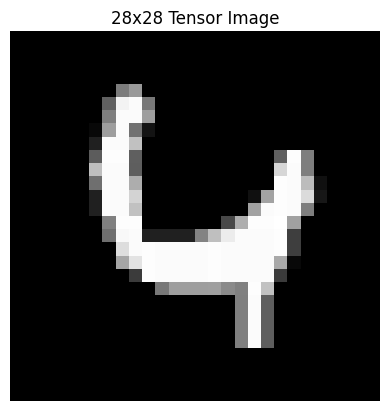

In [5]:
import matplotlib.pyplot as plt

def image_reshape(images):
    """
    Function to resize images from the dataloaders.

    Inputs:
    - images: tensor containing a batch of images.
    Shape: (batch_size, num_observed_vars)

    Outputs:
    - images: tensor containing a batch of resized images.
    Shape: (batch_size, image_height, image_width, image_channels)
    """

    images = images.reshape((-1, 1, 28, 28))
    return images

for (images, digits) in train_loader:
    images = image_reshape(images)
    print(images.shape)
    plt.imshow(images[0, 0, :, :], cmap='gray')
    plt.title("28x28 Tensor Image")
    plt.axis('off')  # Hide axes
    plt.show()

    break

### Loss Functions

In [6]:
def diag_normal_std_normal_KL(mu, sigma):
  """
  Function to compute KL divergence between the given diagonal normal distribution and the standard normal
  distribution, N(0, I). This is equivalent to multivariate_normal_KL_divergence(), except it is
  more efficient when the second distribution is the standard normal. Closed form is obtained from
  https://arxiv.org/pdf/1606.05908.

  This function is vectorised.

  Inputs:
  - mu: a vector of means for the distribution.
  Shape: (*, n_vars)
  - sigma: a vector of covariance diagonals for the distribution.
  Shape: (*, n_vars)

  Outputs:
  - KL_divergence: computed KL divergence, D(distribution_1, N(0, I)).
  Shape: (*)
  """

  #Initialise variables
  k = mu.shape[-1]

  #Compute traces and log determinants (det of diagonal is product of diagonals)
  sigma_traces = sigma.sum(-1)
  sigma_log_det = torch.sum(torch.log(sigma), dim = -1)

  #Compute KL-divergence
  KL_divergence = 1/2 * ( sigma_traces + torch.sum(mu ** 2, dim = -1) - k - sigma_log_det )

  return KL_divergence


def loss_per_batch(X, z, Q, P):
  """
  Function to compute loss over entire batch. In a VAE, this is the negative of the evidence lower bound (ELBO).
  We wish to maximise the ELBO, hence we minimise the negative ELBO. 
  The negative ELBO is given by KL_divergence - P_log_likelihood.

  Note that we assume that the latent variables z are drawn from a multivariate standard normal 
  distribution, N(0, I).

  Here, "P" refers to our map from latent variables to data points, P(X|z).

  Inputs:
  - X: tensor containing the observed data points for a batch.
  Shape: (batch_size, n_observed_vars)
  - z: tensor containing the latent variables corresponding to the given observed data points.
  Note that we allow multiple latent variable samples for a single data point, as z_batch_size 
  does not need to be 1.
  Shape: (batch_size, z_batch_size, n_latent_vars)
  - Q: normal distribution for Q(z|X).
  Shape: (batch_size, n_latent_vars)
  - P: normal distribution for P(X|z).
  Shape: (batch_size, z_batch_size, n_observed_vars)

  Note that Q and P are normal distributions objects, not multivariate normal objects. This is
  because we assume that the covariance matrices are diagonal.

  Outputs:
  - P_log_likelihood: log likelihood of the observed data points given the latent variables.
  Shape: (batch_size)
  - KL_divergence: KL divergence between the given Q(z|X) and the standard normal distribution N(0, I).
  Shape: (batch_size)

  Note that the ELBO (which is a single value for loss) is KL_divergence - P_log_likelihood.
  """

  #Initialise variables
  #n_observed = X.shape[-1]
  #n_latent = z.shape[-1]
  z_batch_size = z.shape[1]
  #batch_size = z.shape[0]

  #Compute loss per data point
  #Note that Pytorch should automatically implement the reparametrisation trick here.
  P_log_likelihood = P.log_prob(X.unsqueeze(1).repeat(1, z_batch_size, 1))
  #Sum over observed variables and average over latent variables
  P_log_likelihood = torch.mean(torch.sum(P_log_likelihood, dim = 2), dim = 1)
  KL_divergence = diag_normal_std_normal_KL(Q.loc, Q.scale)

  return P_log_likelihood, KL_divergence

print("All functions generated")

All functions generated


### Tests for the Functions Above

In [7]:
torch.manual_seed(42)

n_observed = 10
n_latent = 5

batch_size = 32

Z_mu = torch.zeros(n_latent)
Z_sigma = torch.eye(n_latent)
Z = torch.distributions.MultivariateNormal(Z_mu, Z_sigma)

Q_mu = Z.sample((batch_size,))
Q_sigma = torch.abs(Z.sample((batch_size,)))

#Compute KL-divergence between Q and I manually
Q = torch.distributions.Normal(Q_mu, Q_sigma)
test_KL = diag_normal_std_normal_KL(Q_mu, Q_sigma)
Q_sigma = torch.diag_embed(Q_sigma)
Q_multi = torch.distributions.MultivariateNormal(Q_mu, Q_sigma)
expected_KL = torch.distributions.kl_divergence(Q_multi, Z)

manual_KL = torch.zeros((batch_size,))
for i in range(batch_size):
    manual_KL[i] = 1/2 * (torch.log(torch.linalg.det(Z_sigma) / torch.linalg.det(Q_sigma[i, :, :])) - n_latent + torch.trace(torch.linalg.inv(Z_sigma) @ Q_sigma[i, :, :]) + (Z_mu - Q_mu[i, :]).T @ torch.linalg.inv(Z_sigma) @ (Z_mu - Q_mu[i, :]))

#Test 1: normal_KL_divergence_from_standard_normal()
print(f"\n\nnormal_KL_divergence_from_standard_normal test.\nExpected value==Test Value: {torch.allclose(expected_KL, test_KL, atol=1e-5, rtol=1e-3)}.\nManually-calculated value == Expected Value: {torch.allclose(manual_KL, expected_KL, atol=1e-5, rtol=1e-3)}.\nManually-calculated value == Test Value: {torch.allclose(manual_KL, test_KL, atol=1e-5, rtol=1e-3)}")
#print("manual_KL: ", manual_KL)
#Test passed

#Initialise variables
z_batch_size = 3

#Create new distribution, P=P(X|z)
Z_mu = torch.zeros(n_observed)
Z_sigma = torch.eye(n_observed)
Z = torch.distributions.MultivariateNormal(Z_mu, Z_sigma)
P_mu = Z.sample((batch_size, z_batch_size))
P_sigma = torch.abs(Z.sample((batch_size, z_batch_size)))
P = torch.distributions.Normal(P_mu, P_sigma)
manual_P_log_likelihood = torch.zeros((batch_size, z_batch_size, n_latent))

#Sample a single batch of X
#In practice this would be conditioned on a sample of z from Q
X = P.sample((1,)).squeeze()[:, 0, :]
Z_mu = torch.zeros(n_latent)
Z_sigma = torch.eye(n_latent)
Z = torch.distributions.MultivariateNormal(Z_mu, Z_sigma)

#Sample z from Q, then compute log-likelihood of X given z
z = Q.rsample((z_batch_size,))
z = z.permute(1, 0, 2)  # Shape: (batch_size, z_batch_size, n_latent_vars)
manual_P_log_likelihood = P.log_prob(X.unsqueeze(1).repeat(1, z_batch_size, 1))
manual_P_log_likelihood = torch.mean(torch.sum(manual_P_log_likelihood, dim=2), dim = 1)
manual_KL_divergence = torch.distributions.kl_divergence(Q_multi, Z)

#Average over all z samples
manual_loss = -manual_P_log_likelihood + manual_KL_divergence
test_P_log_likelihood, test_KL_divergence = loss_per_batch(X, z, Q, P)
test_loss = -test_P_log_likelihood + test_KL_divergence

#TEST 2: loss_per_batch
print(f"\n\nloss_per_batch test.\nExpected_value == Obtained_value: {torch.allclose(manual_loss, test_loss, atol=1e-5, rtol=1e-3)}.")
#Test passed



normal_KL_divergence_from_standard_normal test.
Expected value==Test Value: True.
Manually-calculated value == Expected Value: True.
Manually-calculated value == Test Value: True


loss_per_batch test.
Expected_value == Obtained_value: True.


C:\Users\kperc\AppData\Local\Temp\ipykernel_524\4024282803.py:24: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4416.)
  manual_KL[i] = 1/2 * (torch.log(torch.linalg.det(Z_sigma) / torch.linalg.det(Q_sigma[i, :, :])) - n_latent + torch.trace(torch.linalg.inv(Z_sigma) @ Q_sigma[i, :, :]) + (Z_mu - Q_mu[i, :]).T @ torch.linalg.inv(Z_sigma) @ (Z_mu - Q_mu[i, :]))


### Model

We will use Optuna to find the optimal set of hyperparameters.

In [8]:
def init_weights(layer):
    """
    Function to initialise weights of a layer.

    Inputs:
    - layer: a layer of the neural network.

    Note that there are no outputs, as the weights are initialised in place.
    """

    #Only update parameters if the layer is a linear layer
    if isinstance(layer, torch.nn.Linear):
        #Initialise weights using Xavier uniform distribution and biases to zero
        torch.nn.init.xavier_uniform_(layer.weight)
        torch.nn.init.zeros_(layer.bias)
    
    return None

#Create Neural Network Model
class neural_network(torch.nn.Module):
    """
    Create class for a neural network with a variable number of layers.
    """

    def __init__(self, hidden_sizes, n_inputs, n_outputs, tanh_output, dropout_rate = 0.5):
        """
        Initialise the model and relevant hyperparameters

        Inputs:
        - hidden_sizes: a list containing the number of neurons in each layer in the neural network.
        - n_inputs: the number of inputs to be produced by the neural network.
        - n_outputs: the number of outputs to be produced by the neural network.
        - logistic_output: a boolean which determines whether the output layer should use a logistic 
        activation function.
        - dropout_rate: the dropout rate to be applied after each layer.
        """

        super(neural_network, self).__init__()

        self.hidden_sizes = hidden_sizes
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.tanh_output = tanh_output
        self.dropout_rate = dropout_rate

        #Create a ModuleList to hold the layers and dropout rates
        self.layers = torch.nn.ModuleList()
        self.dropouts = torch.nn.ModuleList()

        #Create layers of neural network
        in_size = n_inputs
        for out_size in hidden_sizes:
            self.layers.append(torch.nn.Linear(in_size, out_size))
            self.dropouts.append(torch.nn.Dropout(p=dropout_rate))

            #Update number of inputs for next layer
            in_size = out_size

        #Add final layer to produce outputs
        #Note that we do not apply dropout to the output layer.
        self.layers.append(torch.nn.Linear(in_size, n_outputs))

        #Initialise weights of each layer
        self.layers.apply(init_weights)

    def forward(self, X):
        """ 
        Establish how inputs move through the neural network. This is where we set the 
        activation function.

        Inputs:
        - X: tensor of inputs.
        Shape: (batch_size, n_inputs)

        Outputs:
        - X: tensor of outputs. If self.logistic_output is True, then the elements are between 0 and 
        1, else they can take any real value.
        Shape: (batch_size, n_outputs)
        """

        #Apply each layer in the neural network
        #We apply the final layer separately, as we do not apply dropout.
        for i, layer in enumerate(self.layers[:-1]):
            X = torch.nn.functional.relu(layer(X))
            X = self.dropouts[i](X)
        # Apply output layer (no activation or dropout)
        X = self.layers[-1](X)

        #Apply logistic function to outputs if specified
        if self.tanh_output == True:
            X = torch.tanh(X)

        #Error handling: ensure that outputs don't contain NaN or Inf values
        if torch.isnan(X).any() or torch.isinf(X).any():
            raise ValueError("Neural network output contains NaN or Inf values.")

        return X

class VAE(torch.nn.Module):
    """      
    Create VAE model. The main goal is to estimate the following with neural networks:
    - f = f(z; theta): this is a map from latent variables to a point estimate for X, as we assume that
    P(X|z) has distribution N( f(z; theta), sigma^2*I ). 
    - mu = mu(X; phi) and sigma = sigma(X; phi): these parametrise Q(z|X), which we assume to have 
    distribution N( mu(X; phi), sigma(X; phi) ).
    """

    def __init__(self, n_observed, n_latent, f_hidden_sizes, Q_hidden_sizes, z_batch_size):
        """
        Initialise the model and relevant hyperparameters

        Inputs:
        - n_observed: the number of observed variables
        - n_latent: the number of latent variables
        - f_hidden_sizes: a list for the number of hidden sizes in the neural network f(z; theta).
        - Q_hidden_sizes: a list for the number of hidden sizes in the neural network for 
        the parameters of Q (mu(X; phi) and sigma(X; phi)).
        - z_batch_size: the number of latent variables to sample per observed data point.

        Notes:
        - self.n_outputs depends on the number of latent and observed variables. 
        - self.log_sigma2 is a parameter of the model, as it is not specific to each data point
        (homoscedastic variance). We use log variance, as then taking the exponential ensures varaince
        is positive.
        """

        super(VAE, self).__init__()

        #Initialise hyperparameters
        self.n_observed = n_observed
        self.n_latent = n_latent
        self.z_batch_size = z_batch_size

        #Initialise log variance to a small value to avoid posterior collapse.
        #Note that this will be optimised globally (a single value for all data points).
        self.log_sigma2 = torch.nn.Parameter(torch.tensor([-4.0]))

        #Initialise instances of neural networks.
        #Recall that f maps z to X and Q maps X to z, so this determines the number of inputs and outputs.
        #For Q, mu and sigma both have n_latent elements, hence the total outputs is 2*n_latent.
        self.f_nn = neural_network(f_hidden_sizes, n_latent, n_observed, True)
        self.Q_n_outputs = 2*n_latent
        self.Q_nn = neural_network(Q_hidden_sizes, n_observed, self.Q_n_outputs, False)

    def forward(self, inputs, skip_encode = False):
        """
        Forward function for the VAE model. Here, we use Q to encode our data, then f to decode.

        Inputs:
        - inputs: depends on skip_encode (see below).
        - skip_encode: a boolean which determines whether "inputs" are observed data points or latent
        variables.
        if skip_encode == False:
            inputs is a tensor of observed data.
            Shape: (batch_size, n_observed)
        if skip_encode == True:
            inputs is a tensor of latent variables.
            Shape: (batch_size,  z_batch_size, n_latent)

        Outputs:
        - outputs: a tuple, where the elements depends on skip_encode.
        if skip_encode == False:
            - z: samples from Q, which represent likely latent variables corresponding to each observed
            data point.
            Shape: (batch_size, z_batch_size, n_latent)
            - Q: distribution for Q(z|X), which is a normal distribution.
            Shape: (batch_size, n_latent).
            - P: distribution for P(X|z), which is a normal distribution.
            Shape: (batch_size, z_batch_size, n_observed).
        if skip_encode == True:
            - P: see above.

        Note that point estimates for the reconstructed data is given by the mean of P (=f(z; theta)).

        """

        #Initialise variables
        batch_size = inputs.shape[0]

        if skip_encode == True:
            #Relabel inputs
            z = inputs

        else:
            #Relabel inputs
            X = inputs

            #Encode data as probability distributions
            #Elements of variance matrix must be positive, so take exponential.
            Q_parameters = self.Q_nn(X)
            Q_mu = Q_parameters[:, 0:self.n_latent]
            #Clamp values to avoid numerical issues before taking exponential
            Q_sigma = torch.exp(torch.clamp(Q_parameters[:, self.n_latent:], min=-10, max=10))
            Q = torch.distributions.Normal(Q_mu, Q_sigma)

            #Sample from Q to get encoded variables.
            #Permute dimensions so that z has the intended shape: (batch_size, z_batch_size, n_latent)
            z = Q.rsample((self.z_batch_size,))
            z = torch.movedim(z, 0, 1) 

        #Decode sampled latent variables.
        #Here, f is the point estimate for X, i.e. it is our reconstructed observed data.
        f = self.f_nn(z)
        P_mu = f
        #Clamp log_sigma2 to avoid numerical issues before taking exponential
        sigma2 = torch.exp(torch.clamp(self.log_sigma2, min=-10, max=10))
        P_sigma = sigma2 * torch.ones((batch_size, self.z_batch_size, self.n_observed))
        P = torch.distributions.Normal(P_mu, P_sigma)

        #Outputs depend on whether we skipped encoding or not
        if skip_encode == True:
            outputs = ( P )
        else: 
            outputs = ( z, Q, P )
        return outputs



Test function for VAE model

In [9]:
#Extract a single batch
for images, digits in train_loader:
    break

#Initialise hyperarameters
n_observed = images.shape[-1]
n_latent = 5
f_hidden_sizes = [10, 12]
Q_hidden_sizes = [20, 24, 28]
sigma = 1
z_batch_size = 7

test_model = VAE(n_observed, n_latent, f_hidden_sizes, Q_hidden_sizes, z_batch_size)

#Test full model
z, Q, P = test_model(images, skip_encode = False)
print(f"Q_mu.shape: {Q.loc.shape}, Q_sigma.shape: {Q.scale.shape}, z.shape: {z.shape}, P_mu.shape: {P.loc.shape}, P_sigma.shape: {P.scale.shape}")

#Test only decoder
z = torch.distributions.MultivariateNormal(torch.zeros(n_latent), torch.eye(n_latent)).sample((batch_size, z_batch_size))
P = test_model(z, skip_encode = True)
print(f"P_mu.shape: {P.loc.shape}, P_sigma.shape: {P.scale.shape}")

Q_mu.shape: torch.Size([32, 5]), Q_sigma.shape: torch.Size([32, 5]), z.shape: torch.Size([32, 7, 5]), P_mu.shape: torch.Size([32, 7, 784]), P_sigma.shape: torch.Size([32, 7, 784])
P_mu.shape: torch.Size([32, 7, 784]), P_sigma.shape: torch.Size([32, 7, 784])


### Train and Test Functions for VAE

In [10]:
import optuna

def train_VAE(train_loader, test_loader, model, n_epochs, optimiser, print_flag = False):
  """
  Function to train the VAE.

  Inputs:
  - train_loader: the `DataLoader` object for the training dataset.
  - test_loader: the `DataLoader` object for the testing dataset.
  - model: the VAE model to be trained.
  - n_epochs: number of times to loop through entire dataset during optimisation.
  - print_flag: a boolean which determines whether to print training statistics.

  Outputs:
  - model: trained VAE model.
  - epoch_train_losses: tensor of loss per epoch over the training dataset.
  Shape: (n_epochs,)
  - epoch_test_losses: tensor of loss per epoch over the testing dataset.
  Shape: (n_epochs,)
  """
  
  #Set model to training mode
  model.train()

  #Initialise variables
  n_batches = len(train_loader)
  batch_sizes = [len(batch) for batch in train_loader]
  n_checkpoints = 3
  train_size = len(train_loader.dataset)
  #Only want to print n_checkpoints times per epoch
  checkpoints = [torch.floor(torch.tensor((n_batches-1)/n_checkpoints * (i))) for i in range(n_checkpoints+1)]
  i = 0
  epoch_train_losses = torch.zeros((n_epochs,))
  epoch_test_losses = torch.zeros((n_epochs,))

  #Loop through entire dataset the specified number of times
  for epoch_index in range(n_epochs):
    #Keep track of epoch P_log_likelihood and KL_divergence - these are used to compute loss
    train_P_log_likelihood = 0
    train_KL_divergence = 0

    #Initialise beta for annealing. Start close to 0, increase linearly to 1.0.
    Beta = 1.0 * (epoch_index) / (n_epochs-1)

    for batch_index, (images, digits) in enumerate(train_loader):
      #Compute loss
      #Note that we use annealing for batch_loss, as this is used for the optimiser
      z, Q, P = model(images, skip_encode = False)
      batch_P_log_likelihood, batch_KL_divergence = loss_per_batch(images, z, Q, P)
      batch_P_log_likelihood = torch.sum(batch_P_log_likelihood)
      batch_KL_divergence = torch.sum(batch_KL_divergence)
      batch_loss = Beta * batch_KL_divergence - batch_P_log_likelihood
      train_P_log_likelihood += batch_P_log_likelihood/train_size
      train_KL_divergence += batch_KL_divergence/train_size
      
      #Update parameters based on optimiser
      optimiser.zero_grad()
      batch_loss.backward()
      optimiser.step()

      #Only print occasional batch statistics
      if (print_flag == True) and (batch_index == checkpoints[i]):
        current_batch_size = batch_sizes[batch_index]
        print(f"Batch number: {batch_index+1}/{n_batches}. Average P_log_likelihood: {batch_P_log_likelihood/current_batch_size}. Average KL_divergence: {batch_KL_divergence/current_batch_size}.")
        i += 1
        
    #Reset i for next epoch
    i = 0

    #Store epoch losses. Note that we do not use annealing to stay consistent
    epoch_train_losses[epoch_index] = -train_P_log_likelihood + train_KL_divergence
    test_P_log_likelihood, test_KL_divergence = test_VAE(test_loader, model)
    epoch_test_losses[epoch_index] = -test_P_log_likelihood + test_KL_divergence

    #Print epoch statistics
    if print_flag == True:
      print(f"\nEpoch number: {epoch_index+1}/{n_epochs}.")
      print(f"Train loss: {epoch_train_losses[epoch_index]}, Train P_log_likelihood: {train_P_log_likelihood}, Train KL_divergence: {train_KL_divergence}.")
      print(f"Test loss: {epoch_test_losses[epoch_index]}, Test P_log_likelihood: {test_P_log_likelihood}, Test KL_divergence: {test_KL_divergence}.\n")

  return model, epoch_train_losses, epoch_test_losses




def test_VAE(test_loader, model):
  """
  Function to test the VAE.

  Inputs:
  - test_loader: the `DataLoader` object for the testing dataset.
  - model: the VAE model to be trained.

  Outputs:
  - loss: total training loss for the model
  """

  #Set model to evaluation mode
  model.eval()

  #Initialise variables
  P_log_likelihood = 0
  KL_divergence = 0
  test_size = len(test_loader.dataset)

  #Loop through dataset
  for batch_index, (images, digits) in enumerate(test_loader):      
      #Compute loss
      z, Q, P = model(images, skip_encode = False)
      batch_P_log_likelihood, batch_KL_divergence = loss_per_batch(images, z, Q, P)
      P_log_likelihood += torch.sum(batch_P_log_likelihood)/test_size
      KL_divergence += torch.sum(batch_KL_divergence)/test_size

  return P_log_likelihood, KL_divergence


def objective(trial, train_loader, test_loader, z_batch_size, n_epochs):
  """  
  Objective function for Optuna to optimise. Here, hyperparameters are suggested by the package.
  
  Inputs:
  - trial: optuna.trial.Trial object
  - train_loader & test_loader: dataloaders for the training and testing datasets.
  - z_batch_size: number of latent samples per data point to compute gradient.
  - n_epochs: number of times to loop through entire dataset.

  Outputs:
  - loss: scalar value for the loss across the entire test dataset.
  """

  #Suggest hyperparameters
  n_latent = trial.suggest_int("n_latent", 5, 25)
  f_n_layers = trial.suggest_int("f_n_layers", 1, 3)
  Q_n_layers = trial.suggest_int("Q_n_layers", 1, 3)
  #We will start with all layers having equal size
  f_hidden_size = trial.suggest_int("f_hidden_size", 8, 64)
  Q_hidden_size = trial.suggest_int("Q_hidden_size", 128, 1024)
  learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)
  #dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)

  #Initialise variables and other hyperparameters
  f_hidden_sizes = [f_hidden_size for _ in range(f_n_layers)]
  Q_hidden_sizes = [Q_hidden_size for _ in range(Q_n_layers)]
  for (images, digits) in train_loader:
    break
  #Number of observed variables is product of all dimension lengths except first (batch)
  n_observed = torch.prod(torch.tensor(images[(0,) + (slice(None),) * (images.dim() - 1)].shape))

  #Initialise model and optimiser
  model = VAE(n_observed, n_latent, f_hidden_sizes, Q_hidden_sizes, z_batch_size)
  #model = torch.compile(model)
  optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

  #Train model
  #Add error handling in the case that NaN or Inf values are produced
  try:
     model, _, epoch_test_losses = train_VAE(train_loader, test_loader, model, n_epochs, optimiser, print_flag = False)
  except ValueError as e:
      print(f"Error during training: {e}")
      raise optuna.TrialPruned()
  
  #Extract final test loss
  loss = epoch_test_losses[-1]

  return loss
  


c:\Users\kperc\VAE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Run Training and Testing

In [11]:
#Initialise hyperparameters
for (images, digits) in train_loader:
    break
batch_size = images.shape[0]
z_batch_size = 1
n_epochs = 20
optuna_n_trials = 1 #Full study has already been run, so we only need to run one trial to load the study
load_study = True

#Delete existing study if it exists
study_name = "VAE MNIST Optuna Study"
storage_url = "sqlite:///VAE_MNIST_Optuna_Study.db"
if load_study == False:  
    try:
        optuna.delete_study(study_name=study_name, storage=storage_url)
        print(f"Deleted existing study: {study_name}")
    except KeyError:
        print(f"No existing study named '{study_name}' found. Creating a new one.")

# Run the study
study = optuna.create_study(direction="minimize",
                            study_name=study_name,
                            storage=storage_url,  
                            load_if_exists=load_study)
study.optimize(lambda trial: objective(trial, train_loader, test_loader, z_batch_size, n_epochs), n_trials=optuna_n_trials)

# Best result
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print(f"  Params: {best_trial.params}")

[I 2025-06-13 06:41:19,189] Using an existing study with name 'VAE MNIST Optuna Study' instead of creating a new one.
[I 2025-06-13 07:28:37,454] Trial 50 finished with value: 148.7819366455078 and parameters: {'n_latent': 8, 'f_n_layers': 1, 'Q_n_layers': 3, 'f_hidden_size': 51, 'Q_hidden_size': 807, 'learning_rate': 0.00039725240074230095}. Best is trial 37 with value: -195.24118041992188.


Best trial:
  Value: -195.24118041992188
  Params: {'n_latent': 25, 'f_n_layers': 1, 'Q_n_layers': 3, 'f_hidden_size': 51, 'Q_hidden_size': 941, 'learning_rate': 0.0002915168436070506}


### Optuna Trial Evaluations

In [12]:
!pip install scikit-learn

In [15]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Show optimization history (objective value per trial)
fig1 = plot_optimization_history(study)
fig1.show()

# Show parameter importances
fig2 = plot_param_importances(study)
fig2.show()

# Show parallel coordinate plot (hyperparameters vs. objective)
fig3 = plot_parallel_coordinate(study)
fig3.show()

# Show slice plot (parameter values vs. objective)
fig4 = plot_slice(study)
fig4.show()

### Use Best Model

In [14]:
# Get the best trial's parameters
best_params = study.best_trial.params

#Increase number of epochs for final training
n_epochs += 10

# Rebuild the model using the best parameters
n_latent = best_params["n_latent"]
f_n_layers = best_params["f_n_layers"]
Q_n_layers = best_params["Q_n_layers"]
f_hidden_size = best_params["f_hidden_size"]
Q_hidden_size = best_params["Q_hidden_size"]
learning_rate = best_params["learning_rate"]

f_hidden_sizes = [f_hidden_size for _ in range(f_n_layers)]
Q_hidden_sizes = [Q_hidden_size for _ in range(Q_n_layers)]

# Get n_observed from your data
for (images, digits) in train_loader:
    break
n_observed = torch.prod(torch.tensor(images[(0,) + (slice(None),) * (images.dim() - 1)].shape))

# Rebuild and retrain the model
best_model = VAE(n_observed, n_latent, f_hidden_sizes, Q_hidden_sizes, z_batch_size)
optimiser = torch.optim.Adam(best_model.parameters(), lr=learning_rate)
best_model, epoch_train_losses, epoch_test_losses = train_VAE(train_loader, test_loader, best_model, n_epochs, optimiser, print_flag = True)

print("\nRe-training Complete.\n")

Batch number: 1/1875. Average P_log_likelihood: -23665528.0. Average KL_divergence: 528.9310913085938.
Batch number: 625/1875. Average P_log_likelihood: -3709618.75. Average KL_divergence: 1471.3480224609375.
Batch number: 1250/1875. Average P_log_likelihood: -2409182.0. Average KL_divergence: 2946.37158203125.
Batch number: 1875/1875. Average P_log_likelihood: -1774271.75. Average KL_divergence: 4137.47216796875.

Epoch number: 1/30.
Train loss: 220707.53125, Train P_log_likelihood: -220552.078125, Train KL_divergence: 155.4524688720703.
Test loss: 90723.5390625, Test P_log_likelihood: -90510.6875, Test KL_divergence: 212.85154724121094.

Batch number: 1/1875. Average P_log_likelihood: -1259457.125. Average KL_divergence: 3851.816650390625.
Batch number: 625/1875. Average P_log_likelihood: -803035.5625. Average KL_divergence: 19511.259765625.
Batch number: 1250/1875. Average P_log_likelihood: -640492.75. Average KL_divergence: 31287.03515625.
Batch number: 1875/1875. Average P_log_lik

Plot training and testing losses over time

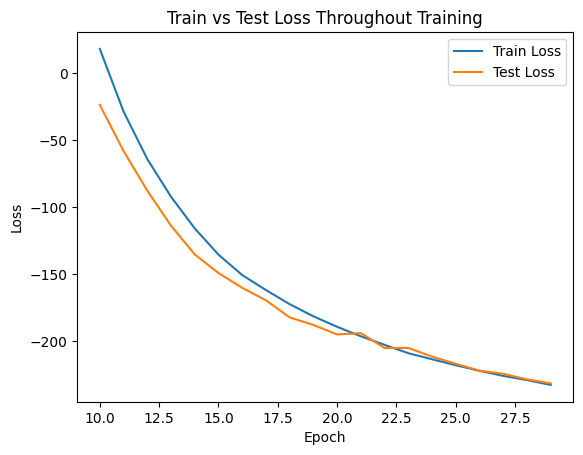

In [28]:
import matplotlib.pyplot as plt

#Plot train and test losses
#Exclude first 10 epochs to avoid initial instability
start_epoch = 10
x_axis = np.arange(start_epoch, len(epoch_train_losses))
plt.plot(x_axis, epoch_train_losses.detach().numpy()[start_epoch:], label='Train Loss')
plt.plot(x_axis, epoch_test_losses.detach().numpy()[start_epoch:], label='Test Loss')
#plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss Throughout Training')
plt.legend()
plt.show()

Sample a batch from the test dataloader, then sample from the model to get similar data points.



Create new images via sampling.


(32, 1, 28, 28)


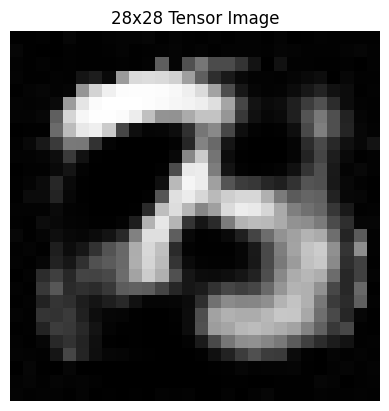



Create similar images to test dataset.



True image.



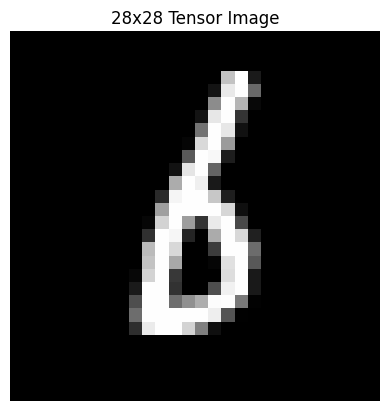


Similar image.



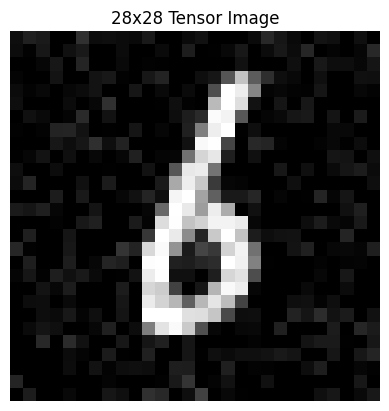

In [50]:
#Create new batch by sampling from standard normal distribution
#Shape we need: (batch_size, z_batch_size, n_latent)
sampled_z = torch.randn((batch_size, z_batch_size, n_latent))

#Run model with sampled z
P = best_model(sampled_z, skip_encode=True)

#Extract the mean of the distribution P. This is a point estimate for the reconstructed data.
#We also take the mean over z_batch_size, as we want a single point estimate for each data point.
P_mu = P.loc
P_mu = torch.mean(P_mu, dim=1)

#Visualise the reconstructed images
print("\n\nCreate new images via sampling.\n\n")
images = image_reshape(P_mu).detach().numpy()
print(images.shape)
plt.imshow(images[5, 0, :, :], cmap='gray')
plt.title("28x28 Tensor Image")
plt.axis('off')  # Hide axes
plt.show()


#print("first image: ", images[0, 0, :, :])

#Alternatively, we can try to sample points similar to a given image.
print("\n\nCreate similar images to test dataset.\n\n")
for (images, digits) in train_loader:
    z, Q, P = best_model(images, skip_encode = False)

    similar_data = P.sample((1,)) 
    similar_data = torch.clamp(similar_data, -1, 1)

    #Reshape images
    images = image_reshape(images)
    similar_images = image_reshape(similar_data).detach().numpy()

    #Plot the true first image, then the reconstructed image
    print("\nTrue image.\n")
    plt.imshow(images[0, 0, :, :], cmap='gray')
    plt.title("28x28 Tensor Image")
    plt.axis('off')  # Hide axes
    plt.show()

    print("\nSimilar image.\n")
    plt.imshow(similar_images[0, 0, :, :], cmap='gray')
    plt.title("28x28 Tensor Image")
    plt.axis('off')  # Hide axes
    plt.show()

    break


### Troubleshooting
Will compare to working code from https://github.com/williamcfrancis/Variational-Autoencoder-for-MNIST

Things to compare:
- loss calculation
- hidden sizes and other hyperparameters?
- 

^Try to change other working VAE to use Gaussians instead of Bernoulli.

## Notes

- Will use $P(X|z) = N(X|f(z; \theta), \sigma^2 * I)$ for a loss function. We wish to maximise this, or equivalently to minimise $-P(X|z)$.
- Could simplify by only feeding through distributions to loss function and leaving it to Pytorch to compute KL-divergence. This would be very simple and allows generalisation to non-normal distributions.
- We will start by minimising $\sigma^2$ as a global parameter, like in the textbook "Understanding 
Deep Learning". But, could improve this in the future.
- Currently estimating $\mu(X; \phi)$ and $\Sigma(X; \phi)$ through a single neural network, although
could separate this...
- We apply a sigmoid function to ensure that the mean of $P(X|z)$, $f(z; \theta)$ is between 0 and 1. But, if we sample from the normal $P(X|z)$, we need to clamp the elements so that they fall between 0 and 1 as well (as normal distributions can take any real value).

### TODO - future
- Add preprocessing - is it best practice to standardise variables to have mean 0 and variance 1?
- Add conditional VAE theory
- Add recent research in Beta-Sigma VAE: https://arxiv.org/pdf/2409.09361